# Examples

This notebook contains two example workflows, both based on matching two versions of S&P 500 companies. Data can be downloaded with the code in the notebook `downloads.ipynb` in the same folder.

Higher level interfaces for the core low-level functions are under development, so that there is some amount of plumbing done in the notebook itself. This will make its way into higher-level interfaces in the library itself.

In [1]:
%matplotlib inline

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder

from ptfidf import utils as ut
from ptfidf.train import aggregation as agg
from ptfidf.train.inference import map_estimate
from ptfidf.train.likelihood import BetaParameters
from ptfidf.prediction import BetaBernoulliModel
from ptfidf import core

In [2]:
def get_evaluation_data(proba, correct_assignments):
    correct_assignments = pd.DataFrame(correct_assignments, columns=['row', 'col'])
    res = ut.sparse_to_frame(proba).merge(correct_assignments.assign(y=1), on=['row', 'col'], how='left')
    res['y'] = res['y'].fillna(0).astype(int)
    return res.rename(columns={'data': 'score'})

# Loading / Preprocessing

In [3]:
# read files and concatenate into single table
datadir = Path('../data').resolve()

test_names, target_names = [
    pd.read_csv(datadir.joinpath(fn)).set_index('symbol')['name']
    for fn in ['slickcharts.csv', 'wikipedia.csv']]

# drop some symbols that are impossible to get correct with current preprocessing

# same company with different share class
duplicate_companies = ['GOOGL', 'NWSA', 'DISCA', 'FOXA', 'UAA']
# No (or almost no) token overlap due to spelling variations
impossible_symbols = ['VFC', 'PHM', 'UNH', 'LLL']
skipped_symbols = duplicate_companies + impossible_symbols

for names in [test_names, target_names]:
    names.drop(skipped_symbols, axis=0, inplace=True)
    names.sort_index(inplace=True)

# correct assignments have the same index in both lists
assert np.all(test_names.index.values == target_names.index.values)

# encoding
all_names = np.concatenate([test_names, target_names])
vec = CountVectorizer(binary=True).fit(all_names)
encoder = LabelEncoder().fit(target_names.index.values)

# model input format for test names
X = vec.transform(test_names)
y = -np.ones(X.shape[0], dtype=int)

# model input format for target names
targets = agg.get_entity_statistics(
    vec.transform(target_names),
    encoder.transform(target_names.index))

# Unsupervised Learning

Instead of manually labelling examples, in unsupervised learing we use Expectation-Maximization to train parameters. We iteratively assign names randomly from the predictive distribution and update parameters using the resulting averaged entity statistics.

Here, we use a poor man's implementation that does not update entity statistics for simplicity. Instead, only global word-level parameters are maintained. We use a single matching sample to obtain the word-level statistics.

Note the marked improvements, especially regarding class separation.

In [4]:
# setup
prior = (np.log(.2), 1.5)
log_odds_matched = np.log(10.)
learning_rate = .4
unsupervised_steps = 20

correct_assignments = [(i, i) for i in range(X.shape[0])]

# init with no assignments
token_stats = (
    agg.get_token_statistics(targets)
    .add(agg.get_observation_token_statistics(X)))
token_prior = map_estimate(token_stats, *prior)
model = BetaBernoulliModel(targets, token_prior, log_odds_matched)

res = pd.DataFrame()
for step in range(unsupervised_steps + 1):
    # E-step: compute random assignments with current parameters
    proba = model.get_proba(X)
    assignments = core.sample_assignments(proba)
    # If proba is not needed, can also use instead
    # assignments = model.sample_assignments(X).ravel()

    # M-step
    # aggregate token-level statistics
    idx = assignments >= 0
    token_stats = (
        agg.get_token_statistics(
            agg.get_entity_statistics(X[idx], assignments[idx], targets.size)
            .add(targets))  # merge assignments into targets
        .add(agg.get_observation_token_statistics(X[~idx])))  # combine with unassigned
    # update parameters
    model.token_prior.update(
        map_estimate(
            token_stats,
            *prior,
            s_init=token_prior.strength,
            pi_init=token_prior.frequency),
        learning_rate / (step + 1.))

    # monitoring
    if step == 0:
        initial_evaluation_data = get_evaluation_data(proba, correct_assignments)
    score = pd.Series({test_names.index[i]: proba[i, j] for i, j in correct_assignments})
    res = res.append(score.reset_index().rename(columns={'index': 'symbol', 0: 'proba'}).assign(step=step))

unsupervised_scores = res.sort_values(['symbol', 'step'])
final_evaluation_data = get_evaluation_data(proba, correct_assignments)

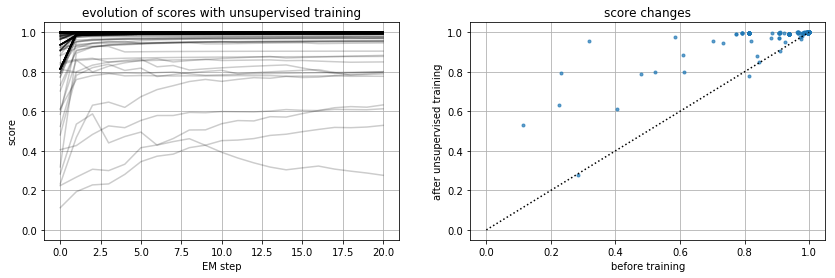

In [5]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 4))

ax = axes[0]
for _, df in unsupervised_scores.groupby('symbol'):
    ax.plot(df['step'].values, df['proba'].values, 'k-', alpha=.2)

ax.set_ylim((-.05, 1.05))
ax.grid()
ax.set_xlabel('EM step')
ax.set_ylabel('score')
ax.set_title('evolution of scores with unsupervised training')

ax = axes[1]
unsupervised_change = unsupervised_scores.groupby('symbol')['proba'].agg(['first', 'last'])
ax.plot(unsupervised_change['first'], unsupervised_change['last'], '.', alpha=.7)
ax.plot([0, 1], [0, 1], 'k:')
ax.grid()
ax.set_title('score changes')
ax.set_xlabel('before training')
ax.set_ylabel('after unsupervised training')
pass

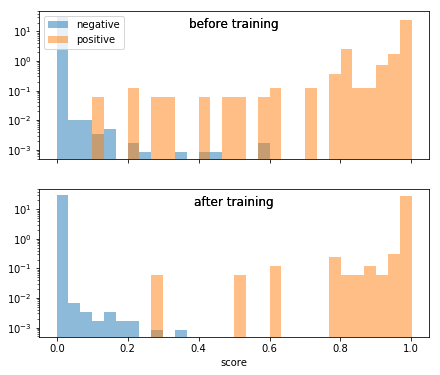

In [6]:
fig, axes = plt.subplots(nrows=2, figsize=(7, 6), sharex=True, sharey=True)

for ax, df, title in zip(axes, [initial_evaluation_data, final_evaluation_data], ['before training', 'after training']):
    for (_y, _df), label in zip(df.groupby('y'), ['negative', 'positive']):
        ax.hist(_df['score'].values, bins=np.linspace(-.001, 1.001, 31), alpha=.5, density=True, log=True, label=label)
        ax.text(.5, .95, title, ha='center', va='top', transform=ax.transAxes, fontsize=12)
        
axes[0].legend(loc='upper left')
axes[1].set_xlabel('score')
pass

# Online Training

For online training, companies are labeled correctly one by one - here in batches of 20. After each batch is labelled by the user, the predictions for the next batch are based on updated parameters from all preceding examples.

The figures below show the change of prediction quality effected through online training. For this small example, most predictions are pretty good without training. For most examples with low initial scores, there is a noticeable improvement. While effects vary depending on the order of batches, the overall effect is very stable.

In [7]:
# setup
prior = (np.log(.2), 1.5)
batch_size = 20
log_odds_matched = np.log(10.)

# init
token_prior = map_estimate(
    agg.get_observation_token_statistics(X).add(agg.get_token_statistics(targets)),
    *prior)
model = BetaBernoulliModel(targets.copy(), token_prior, log_odds_matched)

example_stream = np.random.permutation(X.shape[0])
assignments = -np.ones(X.shape[0], dtype=int)
res = pd.DataFrame()

for train_size in range(0, example_stream.size, batch_size):
    batch = example_stream[train_size:train_size + batch_size]
    unassigned = np.where(assignments == -1)[0]

    # make predictions for unseen examples
    proba = model.get_proba(X[unassigned])

    # add labeled batch to entities
    assignments[batch] = batch
    model.entities.add(agg.get_entity_statistics(X[batch], assignments[batch], model.entities.size))

    # update parameters
    token_stats = (
        agg.get_observation_token_statistics(X[np.setdiff1d(unassigned, batch)])
        .add(agg.get_token_statistics(model.entities)))

    model.token_prior.update(
        map_estimate(
            token_stats,
            *prior,
            s_init=model.token_prior.strength,
            pi_init=model.token_prior.frequency))

    # monitoring
    score = pd.Series({test_names.index[j]: proba[i, j] for i, j in enumerate(unassigned)})
    res = res.append(score.reset_index().rename(columns={'index': 'symbol', 0: 'proba'}).assign(train_size=train_size))

online_scores = res.sort_values(['symbol', 'train_size'])

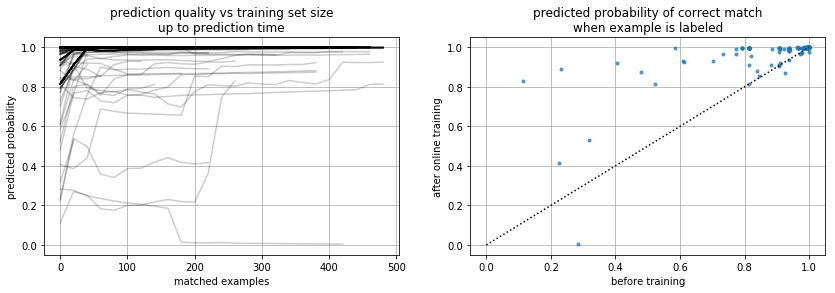

In [8]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 4))

ax = axes[0]
for _, df in online_scores.groupby('symbol'):
    ax.plot(df['train_size'].values, df['proba'].values, 'k-', alpha=.2)

ax.set_ylim((-.05, 1.05))
ax.grid()
ax.set_xlabel('matched examples')
ax.set_ylabel('predicted probability')
ax.set_title('prediction quality vs training set size\nup to prediction time')

ax = axes[1]
online_change = online_scores.groupby('symbol')['proba'].agg(['first', 'last'])
ax.plot(online_change['first'], online_change['last'], '.', alpha=.7)
ax.plot([0, 1], [0, 1], 'k:')
ax.grid()
ax.set_title('predicted probability of correct match\nwhen example is labeled')
ax.set_xlabel('before training')
ax.set_ylabel('after online training')
pass

# Unsupervised vs Online

Hey, unsupervised learning is quite similar to online training!

I think this is because the data set is very easy, so that even without any training most assignments work out correctly. This allows the unsupervised model to learn from many correct assignments.

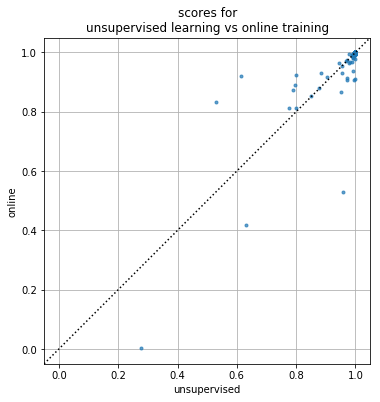

In [9]:
comparison = unsupervised_change.join(online_change, lsuffix='_unsupervised', rsuffix='_online')
assert np.allclose(comparison['first_unsupervised'], comparison['first_online'])

fig, ax = plt.subplots(figsize=(6, 6))
ax.set_title('scores for\nunsupervised learning vs online training')
ax.set_xlabel('unsupervised')
ax.set_ylabel('online')

ax.plot(comparison['last_unsupervised'], comparison['last_online'], '.', alpha=.7)
ax.set_aspect(1)
lim = (-.05, 1.05)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.plot(lim, lim, 'k:')
ax.grid()
pass